# NLP Standard Project:

- Students: **Matteo Belletti**, **Alessandro Pasi**, **Stricescu Razvan Ciprian**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from tqdm import tqdm
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.dummy import DummyClassifier
import pandas as pd
import json
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, accuracy_score, f1_score
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Device: {device}")

c:\Program Files\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


## Data loading and preprocessing:

In [2]:
# open json in project_data_MELD folder
with open('project_data_MELD/MELD_train_efr.json') as f:
    data = json.load(f)
print(f"Number of samples: {len(data)}")
print(f"Example of a sample: {data[0]}")

Number of samples: 4000
Example of a sample: {'episode': 'utterance_0', 'speakers': ['Chandler', 'The Interviewer', 'Chandler', 'The Interviewer', 'Chandler'], 'emotions': ['neutral', 'neutral', 'neutral', 'neutral', 'surprise'], 'utterances': ["also I was the point person on my company's transition from the KL-5 to GR-6 system.", "You must've had your hands full.", 'That I did. That I did.', "So let's talk a little bit about your duties.", 'My duties?  All right.'], 'triggers': [0.0, 0.0, 0.0, 1.0, 0.0]}


In [3]:
# Convert data to pandas dataframe
df = pd.DataFrame(data)
# drop episode and speakers columns
df = df.drop(columns=['episode'])
print(f"Dataframe shape: {df.shape}")
print(f"Dataframe columns: {df.columns}")

Dataframe shape: (4000, 4)
Dataframe columns: Index(['speakers', 'emotions', 'utterances', 'triggers'], dtype='object')


Changing nan values to zeros in order to avoid errors.

In [4]:
df["triggers"] = df["triggers"].apply(lambda x: [0 if elem != 1 and elem != 0 else elem for elem in x])
df["triggers"][3359]

[0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]

Splitting the data into train, validation and test sets with a 80-10-10 ratio.

In [5]:
# Split data 
from sklearn.model_selection import train_test_split

df_train, temp = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(temp, test_size=0.5, random_state=42)

In [6]:
print(f"Train shape: {df_train.shape}")
print(f"Val shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (3200, 4)
Val shape: (400, 4)
Test shape: (400, 4)


As baselines models we need to implement a random model and a majority class model for emotions and triggers.

In [7]:
# first we create a dictionary of all emotions with their corresponding occurences
emotions_dict = {}
for emotions in df_train["emotions"]:
    for emotion in emotions:
        if emotion in emotions_dict:
            emotions_dict[emotion] += 1
        else:
            emotions_dict[emotion] = 1

# then we sort the dictionary by occurences
emotions_dict = {k: v for k, v in sorted(emotions_dict.items(), key=lambda item: item[1], reverse=True)}
print(emotions_dict)

{'neutral': 12066, 'joy': 4986, 'surprise': 3664, 'anger': 3203, 'sadness': 2108, 'fear': 889, 'disgust': 848}


Plotting the distribution of emotions could also be useful.

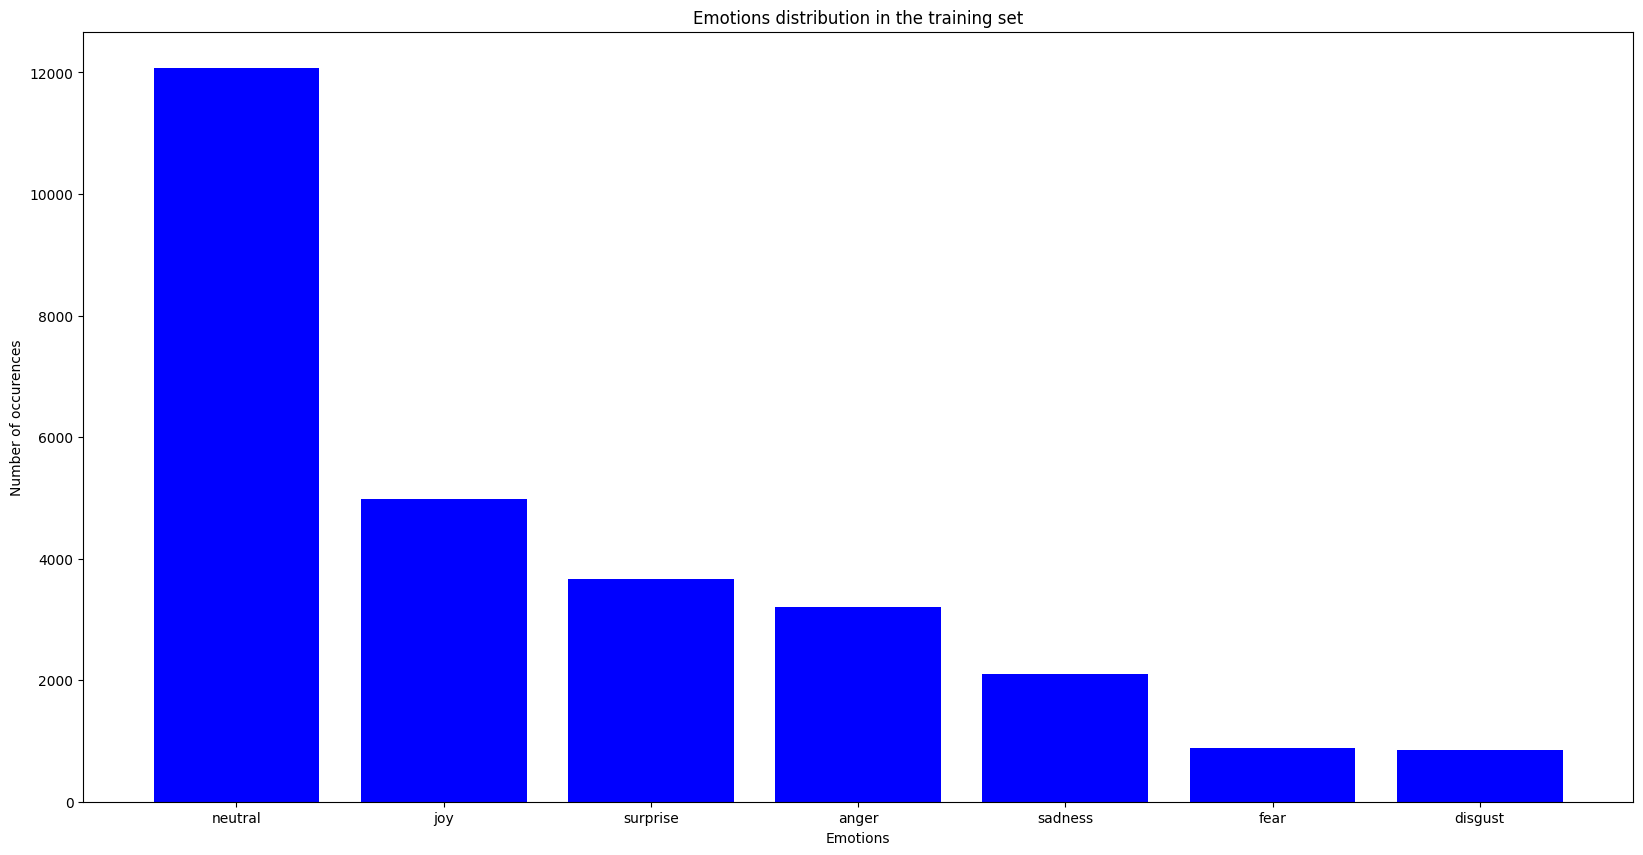

In [8]:
# plot the emotions distribution as histogram
plt.figure(figsize=(20,10))
plt.bar(emotions_dict.keys(), emotions_dict.values(), color='blue')
plt.title("Emotions distribution in the training set")
plt.xlabel("Emotions")
plt.ylabel("Number of occurences")
plt.show()

We can also implement some text processing techniques such as stemming, lemmatization, stop words removal, etc. 

In this case we will use nltk library for lemmatization and stop words removal.

In [9]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
#stop_words = set(stopwords.words('english'))
bad_symbols = re.compile('[^a-z ]')
punct = string.punctuation

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Matteo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Matteo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Matteo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Matteo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


We don't need to use lower case because we are going to use bert uncased models further on.

In [10]:
def preprocess_text(text):
    text = bad_symbols.sub('', text)
    text = word_tokenize(text)
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

In [11]:
baseline_train = df_train.copy()
baseline_train["utterances"] = baseline_train["utterances"].apply(lambda x: [preprocess_text(elem) for elem in x])
baseline_test = df_test.copy()
baseline_test["utterances"] = baseline_test["utterances"].apply(lambda x: [preprocess_text(elem) for elem in x])
baseline_val = df_val.copy()
baseline_val["utterances"] = baseline_val["utterances"].apply(lambda x: [preprocess_text(elem) for elem in x])
print("Shape of train, val and test sets after preprocessing: ")
print(f"Train shape: {baseline_train.shape}")
print(f"Val shape: {baseline_val.shape}")
print(f"Test shape: {baseline_test.shape}")

Shape of train, val and test sets after preprocessing: 
Train shape: (3200, 4)
Val shape: (400, 4)
Test shape: (400, 4)


In order to use the TF-IDF vectorizer we need to split the utterances into single sentences, likewise the emotions and triggers.

In [12]:
def splitter(df, y_label):
    X = []
    y = []
    for index, row in df.iterrows():
        for i in range(len(row["utterances"])):
            X.append(row["utterances"][i])
            y.append(row[y_label][i])
    return X, y

In [13]:
# Emotions baseline
x_train_base, y_train_emotions = splitter(baseline_train, "emotions")
x_val_base, y_val_emotions = splitter(baseline_val, "emotions")
x_test_base, y_test_emotions = splitter(baseline_test, "emotions")

# Triggers baseline
_ , y_train_triggers = splitter(baseline_train, "triggers")
_ , y_val_triggers = splitter(baseline_val, "triggers")
_ , y_test_triggers = splitter(baseline_test, "triggers")

print(f"Train shape after splitting: {len(x_train_base)}")
print(f"Val shape after splitting: {len(x_val_base)}")
print(f"Test shape after splitting: {len(x_test_base)}")

Train shape after splitting: 27764
Val shape after splitting: 3678
Test shape after splitting: 3558


As a tokenizer we use TfidfVectorizer from sklearn.

In [14]:
vectorizer = TfidfVectorizer()

x_train_base = vectorizer.fit_transform(x_train_base)
x_val_base = vectorizer.transform(x_val_base)
x_test_base = vectorizer.transform(x_test_base)

print(f"Train shape after vectorization: {x_train_base.shape}")
print(f"Val shape after vectorization: {x_val_base.shape}")
print(f"Test shape after vectorization: {x_test_base.shape}")

print(f"Size of the vocabulary: {len(vectorizer.vocabulary_)}")

Train shape after vectorization: (27764, 5142)
Val shape after vectorization: (3678, 5142)
Test shape after vectorization: (3558, 5142)
Size of the vocabulary: 5142


Evaluation function that returns the classification report:

In [15]:
def evaluate(Y_test, Y_pred):
    report = classification_report(Y_test, Y_pred, zero_division=0)
    return report

Defining the dummy classifier for emotions and triggers:

In [16]:
dummy_clf_majority_emotions = DummyClassifier(strategy="most_frequent")
dummy_clf_random_emotions = DummyClassifier(strategy="uniform")

dummy_clf_majority_triggers = DummyClassifier(strategy="most_frequent")
dummy_clf_random_triggers = DummyClassifier(strategy="uniform")

Training and evaluation of the classifiers fitted on the training set:

In [17]:
# Emotions baseline
dummy_clf_majority_emotions.fit(x_train_base, y_train_emotions)
dummy_clf_random_emotions.fit(x_train_base, y_train_emotions)

y_pred_majority_emotions = dummy_clf_majority_emotions.predict(x_test_base)
y_pred_random_emotions = dummy_clf_random_emotions.predict(x_test_base)
print("Majority classifier for emotions: \n")
print(evaluate(y_test_emotions, y_pred_majority_emotions))
print("-------------------------------------------------------")
print("Random classifier for emotions: \n")
print(evaluate(y_test_emotions, y_pred_random_emotions))
print("-------------------------------------------------------")

# Triggers baseline
dummy_clf_majority_triggers.fit(x_train_base, y_train_triggers)
dummy_clf_random_triggers.fit(x_train_base, y_train_triggers)

y_pred_majority_triggers = dummy_clf_majority_triggers.predict(x_test_base)
y_pred_random_triggers = dummy_clf_random_triggers.predict(x_test_base)
print("Majority classifier for triggers: \n")
print(evaluate(y_test_triggers, y_pred_majority_triggers))
print("-------------------------------------------------------")
print("Random classifier for triggers: \n")
print(evaluate(y_test_triggers, y_pred_random_triggers))

Majority classifier for emotions: 

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       369
     disgust       0.00      0.00      0.00       101
        fear       0.00      0.00      0.00       109
         joy       0.00      0.00      0.00       663
     neutral       0.44      1.00      0.61      1572
     sadness       0.00      0.00      0.00       258
    surprise       0.00      0.00      0.00       486

    accuracy                           0.44      3558
   macro avg       0.06      0.14      0.09      3558
weighted avg       0.20      0.44      0.27      3558

-------------------------------------------------------
Random classifier for emotions: 

              precision    recall  f1-score   support

       anger       0.09      0.12      0.11       369
     disgust       0.03      0.15      0.05       101
        fear       0.02      0.10      0.04       109
         joy       0.22      0.18      0.20       663
     n

Bert

In [18]:
# get number of sentencese distribution
num_sentences = []
for index, row in df_train.iterrows():
    num_sentences.append(len(row["utterances"]))
print(f"Number of sentences distribution: {num_sentences}")
print(f"Max number of sentences: {max(num_sentences)}")

Number of sentences distribution: [9, 2, 3, 14, 4, 10, 8, 10, 19, 17, 4, 4, 6, 8, 10, 3, 9, 8, 22, 7, 9, 9, 12, 11, 7, 8, 4, 4, 8, 8, 5, 7, 14, 12, 7, 3, 8, 4, 13, 10, 13, 9, 3, 4, 14, 16, 5, 3, 11, 11, 3, 6, 5, 3, 15, 4, 6, 13, 7, 10, 7, 3, 4, 5, 22, 19, 8, 9, 8, 8, 3, 15, 6, 9, 6, 12, 3, 6, 19, 5, 7, 11, 6, 5, 4, 17, 6, 3, 3, 6, 12, 14, 4, 14, 5, 14, 14, 6, 4, 8, 4, 12, 18, 3, 5, 4, 4, 14, 12, 4, 5, 3, 11, 3, 10, 5, 13, 8, 5, 10, 10, 9, 6, 3, 9, 14, 9, 7, 5, 15, 16, 3, 9, 21, 4, 17, 6, 12, 9, 6, 10, 12, 2, 6, 9, 17, 17, 8, 15, 12, 24, 4, 16, 14, 19, 4, 4, 11, 4, 4, 8, 9, 19, 16, 6, 8, 4, 2, 8, 4, 8, 9, 15, 18, 19, 5, 18, 5, 14, 11, 5, 6, 5, 11, 3, 16, 5, 16, 10, 8, 3, 16, 8, 11, 20, 8, 10, 5, 4, 11, 16, 4, 9, 14, 8, 14, 8, 13, 4, 2, 10, 7, 14, 5, 6, 5, 6, 11, 15, 11, 5, 3, 6, 9, 3, 7, 6, 8, 8, 19, 6, 8, 3, 9, 6, 4, 4, 3, 9, 5, 8, 5, 8, 8, 7, 12, 16, 9, 9, 3, 4, 5, 9, 7, 18, 3, 3, 14, 10, 5, 4, 2, 4, 6, 3, 10, 8, 7, 6, 3, 5, 5, 8, 3, 8, 7, 5, 12, 7, 21, 6, 16, 10, 15, 4, 13, 12, 8, 8,

In [19]:
# one hot encode the emotions 
emotions_one_hot_dict = {
    "neutral": [1, 0, 0, 0, 0, 0, 0],
    "joy": [0, 1, 0, 0, 0, 0, 0],
    "surprise": [0, 0, 1, 0, 0, 0, 0],
    "sadness": [0, 0, 0, 1, 0, 0, 0],
    "anger": [0, 0, 0, 0, 1, 0, 0],
    "disgust": [0, 0, 0, 0, 0, 1, 0],
    "fear": [0, 0, 0, 0, 0, 0, 1]
}

In [20]:
bert_train = df_train.copy()
bert_val = df_val.copy()
bert_test = df_test.copy()

In [21]:
bert_train.head(1)

,speakers,emotions,utterances,triggers
3994,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


In [27]:
extended_dataset = None
columns = ["speakers", "emotions", "utterances", "triggers"]
extended_dataset = pd.DataFrame(columns=columns)

for i in range(bert_train.shape[0]):
  for j, _ in enumerate(bert_train.iloc[i]['speakers']):
    new_row = pd.DataFrame({'speakers': [bert_train.iloc[i]['speakers']],
                        'emotions': [bert_train.iloc[i]['emotions'][:j+1]],
                        'utterances': [bert_train.iloc[i]['utterances']],
                        'triggers': [bert_train.iloc[i]['triggers'][:j+1]]})
    extended_dataset = pd.concat([extended_dataset, new_row], ignore_index=True)
extended_dataset

print(f"Shape of the new dataframe: {extended_dataset.shape}")
print(extended_dataset.head())
    


Shape of the new dataframe: (27764, 4)
                                            speakers  \
0  [Chandler, All, Monica, Chandler, Ross, Chandl...   
1  [Chandler, All, Monica, Chandler, Ross, Chandl...   
2  [Chandler, All, Monica, Chandler, Ross, Chandl...   
3  [Chandler, All, Monica, Chandler, Ross, Chandl...   
4  [Chandler, All, Monica, Chandler, Ross, Chandl...   

                                     emotions  \
0                                   [neutral]   
1                              [neutral, joy]   
2                     [neutral, joy, neutral]   
3            [neutral, joy, neutral, neutral]   
4  [neutral, joy, neutral, neutral, surprise]   

                                          utterances  \
0  [Hey., Hey!, So how was Joan?, I broke up with...   
1  [Hey., Hey!, So how was Joan?, I broke up with...   
2  [Hey., Hey!, So how was Joan?, I broke up with...   
3  [Hey., Hey!, So how was Joan?, I broke up with...   
4  [Hey., Hey!, So how was Joan?, I broke up with

In [ ]:
# plt.figure(figsize=(20,10))
# plt.hist(temp["utterances"].apply(lambda x: len(x.split())), bins=100)
# plt.title("Utterances length distribution")
# plt.xlabel("Utterances length")
# plt.ylabel("Number of utterances")
# plt.show()

In [ ]:
# max(temp_train["utterances"].apply(lambda x: len(x.split())))

## Model settings and Bert import

In [24]:
MODEL_NAME = 'prajjwal1/bert-tiny' #'bert-base-uncased'

MAX_LEN = 512
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-05
OUT_CHANNELS = 768 if "base" in  MODEL_NAME else 1024

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config.json: 100%|██████████| 285/285 [00:00<00:00, 284kB/s]
C:\Users\Matteo\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Matteo\.cache\huggingface\hub\models--prajjwal1--bert-tiny. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
vocab.txt: 100%|██████████| 232k/232k 

In [25]:
class CustomDataset(Dataset):

    def __init__(self, data, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = data
        self.speakers = data.speakers
        self.text = data.utterances
        self.emotions = data.emotions
        self.triggers = data.triggers
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        speakers = row["speakers"]
        text = row["utterances"]
        emotions = row["emotions"]
        triggers = row["triggers"]
        target = emotions_one_hot_dict[emotions[-1]]

        text = " "
        for i, d in enumerate(speakers):
            text += f" {d}: {row['utterances'][i]}"

        # We add emotions and triggers to the prompt to give the model information about the other sentences, except for the last which needs to be labeled

        text = text + ' emotions: '
        for i in range(len(emotions)-1):
          text = text + f'{emotions[i]},'

        text = text + ' triggers: '
        for i in range(len(triggers)-1):
          text = text + f'{triggers[i]} '

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'length': torch.tensor(len(speakers), dtype=torch.long),
            'target': torch.tensor(target, dtype=torch.float)
        }

In [33]:
emotions_one_hot_dict[extended_dataset.emotions[0]]

TypeError: unhashable type: 'list'

In [28]:
my_dataset = CustomDataset(extended_dataset, tokenizer, MAX_LEN)

In [27]:
class BERTClass(torch.nn.Module):
    def __init__(self,model):
        super(BERTClass, self).__init__()
        self.l1 = transformers.AutoModel.from_pretrained(model, return_dict=False)
        self.l2 = torch.nn.Dropout(p=0.3)
        self.l3 = torch.nn.Linear(OUT_CHANNELS, 24)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

In [28]:
# TODELETE we don't have to pad them as we will label one sentence at a time and always ask the model for 8 outputs (one for each emotion and the last for trigger)

# pad emotions to max length = 24
# def pad_emotions(emotions):
#     emotions = np.pad(emotions, (0, 24 - len(emotions)), 'constant', constant_values=(0, 0))
#     return emotions

# bert_train["emotions"] = bert_train["emotions"].apply(lambda x: pad_emotions(x))
# bert_val["emotions"] = bert_val["emotions"].apply(lambda x: pad_emotions(x))
# bert_test["emotions"] = bert_test["emotions"].apply(lambda x: pad_emotions(x))

# bert_train["emotions"][0]

array([0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [29]:
train_dataset = CustomDataset(bert_train["utterances"].values, bert_train["emotions"].values, tokenizer, MAX_LEN)
val_dataset = CustomDataset(bert_val["utterances"].values, bert_val["emotions"].values, tokenizer, MAX_LEN)
test_dataset = CustomDataset(bert_test["utterances"].values, bert_test["emotions"].values, tokenizer, MAX_LEN)


print(f"Shape of the training dataset: {len(train_dataset)}")
print(f"Shape of the validation dataset: {len(val_dataset)}")
print(f"Shape of the test dataset: {len(test_dataset)}")

# Definiition of the Dataloader that will feed the data in batches to the neural network for suitable training and processing.
training_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
testing_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Shape of the training dataset: 3200
Shape of the validation dataset: 400
Shape of the test dataset: 400


In [30]:
model = BERTClass(MODEL_NAME)
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [31]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [32]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(training_loader)*EPOCHS)

In [33]:
def train():
    size = len(training_loader.dataset)
    model.train()
    for batch,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if batch%100==0:
            current =  batch * len(data['ids'])
            print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
        

In [34]:
def validation(epoch, val_loss_min_input):
    size = len(testing_loader.dataset)
    num_batches = len(testing_loader)
    model.eval()
    val_loss = 0
    #fin_targets=[]
    #fin_outputs=[]
    with torch.no_grad():
        for batch_idx, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            val_loss += loss_fn(outputs, targets).item()
        
        val_loss /= num_batches
        #outputs, targets = fin_outputs, fin_targets
        print(f"\nValidation loss: {val_loss:>8f}.")
        ## TODO: save the model if validation loss has decreased
        if val_loss <= val_loss_min_input:
            #create checkpoint variable and add important data
            if epoch > 0: 
                print('Validation loss decreased ({:.8f} --> {:.8f}).  Saving model ...'.format(val_loss_min_input, val_loss))
            else: print('Saving model ...')   
            # save best moel
            torch.save(model.state_dict(), "model.pth")
            print("Saved PyTorch Model State to model.pth\n")
            val_loss_min_input = val_loss
    
    return val_loss_min_input

In [36]:
val_loss_min = np.inf
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train()
    val_loss_min = validation(epoch, val_loss_min)

Epoch 1
-------------------------------
Train loss: 0.705146  [    0/ 3200]


KeyboardInterrupt: 